C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

Current K-Fold: 1/5, Epoch 1, Average Loss: 0.6071614113546187
Current K-Fold: 1/5, Epoch 2, Average Loss: 0.4610545846723741
Current K-Fold: 1/5, Epoch 3, Average Loss: 0.43864788355365875
Current K-Fold: 1/5, Epoch 4, Average Loss: 0.4195027536442203
Current K-Fold: 1/5, Epoch 5, Average Loss: 0.3990302518490822
Current K-Fold: 1/5, Epoch 6, Average Loss: 0.38667579475910435
Current K-Fold: 1/5, Epoch 7, Average Loss: 0.37541193394891675
Current K-Fold: 1/5, Epoch 8, Average Loss: 0.36699481236357845
Current K-Fold: 1/5, Epoch 9, Average Loss: 0.3562934756759674
Current K-Fold: 1/5, Epoch 10, Average Loss: 0.35587780538105196
Current K-Fold: 1/5, Epoch 11, Average Loss: 0.3584279655929535
Current K-Fold: 1/5, Epoch 12, Average Loss: 0.347580217305691
Current K-Fold: 1/5, Epoch 13, Average Loss: 0.34085972943613607
Current K-Fold: 1/5, Epoch 14, Average Loss: 0.3179528499322553
Current K-Fold: 1/5, Epoch 15, Average Loss: 0.3507051614503707
Current K-Fold: 1/5, Epoch 16, Average Loss:

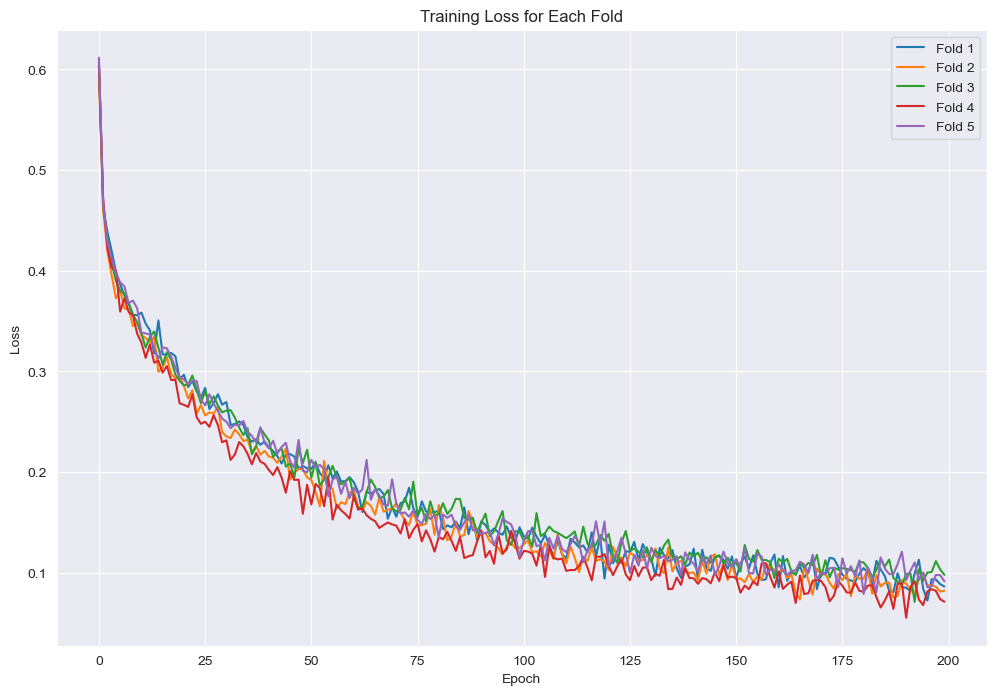

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchinfo import summary

# Check whether GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
df = pd.read_csv('Resources/Data/Encoded_Resampled_HR_Analytics.csv')
X = df.drop('Attrition', axis=1)
y = df['Attrition'].values

# Data Preprocess
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Definition of Neural Networks
class EnhancedNN(nn.Module):
    def __init__(self):
        super(EnhancedNN, self).__init__()
        self.fc1 = nn.Linear(34, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Initialize K-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1s = []
fold_roc_aucs = []
all_train_loss = []
current_fold = 0

for train_index, test_index in skf.split(X, y):
    current_fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

    model = EnhancedNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Track the average training loss for each fold
    fold_train_loss = []

    for epoch in range(200):
        # Track the total loss for the current epoch
        epoch_loss = 0.0
        model.train()

        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            # Cumulative losses
            epoch_loss += loss.item()

        # Record and print the average loss for each epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        fold_train_loss.append(avg_epoch_loss)
        print(f"Current K-Fold: {current_fold}/5, Epoch {epoch+1}, Average Loss: {avg_epoch_loss}")

    all_train_loss.append(fold_train_loss)  # Record the loss for each fold

    model.eval()
    y_pred = []
    y_true = []
    y_scores = []  # Used to store the probability of positive class
    with torch.no_grad():
        for batch in test_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            # Use softmax function to convert to probability
            outputs = F.softmax(outputs, dim=1)
            y_scores.extend(outputs[:,1].tolist())  # Probability of positive class

            y_pred.extend(predicted.tolist())
            y_true.extend(y_batch.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_true, y_scores)

    fold_accuracies.append(accuracy)
    fold_f1s.append(f1)
    fold_roc_aucs.append(roc_auc)

print(f"Average Accuracy: {np.mean(fold_accuracies)}, Average F1 Score: {np.mean(fold_f1s)}, Average ROC AUC: {np.mean(fold_roc_aucs)}")

plt.figure(figsize=(12, 8))
for i, train_loss in enumerate(all_train_loss):
    plt.plot(train_loss, label=f"Fold {i+1}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Each Fold')
plt.legend()
plt.show()

In [19]:
from torchviz import make_dot
model = EnhancedNN()
x = torch.randn(1, 34).requires_grad_(True)
y = model(x)
dot = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
dot.render(filename='model_structure', format='png', cleanup=True)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [4]:
torch.save(model, 'model_complete.pth')

In [18]:
import torch.onnx

dummy_input = torch.randn(1, 34)
dummy_input = dummy_input.to(device)
torch.onnx.export(model, dummy_input, "model.onnx")

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# Load Dataset
df = pd.read_csv('Resources/Data/Encoded_Resampled_HR_Analytics.csv')
X = df.drop('Attrition', axis=1)

# Data Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler
joblib.dump(scaler, 'scaler.joblib')


C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

['scaler.joblib']